Load importance scores. In this example, these are the importance scores for the positive examples for task 0 in the talgata simulation from the deeplift paper (analysis is done on the test set)

In [1]:
!./grab_data.sh

%matplotlib inline
import numpy as np
multipliers = np.load("talgata_task0_positives_multipliers.npy")
deeplift_scores = np.load("talgata_task0_positives_scores.npy")
multipliers = multipliers-np.mean(multipliers,axis=2)[:,:,None] #mean normalization at each position. Could be done more rigorously.
onehot_seq = (np.abs(deeplift_scores) > 0)*1.0
from modisco.visualization import viz_sequence
#viz_sequence.plot_weights(deeplift_scores[0])
#viz_sequence.plot_weights(multipliers[0])

File talgata_task0_positives_multipliers.npy exists already


In [2]:
from modisco import core
reload(core)
deeplift_score_track = core.DataTrack(name="deeplift_scores", fwd_tracks=deeplift_scores,
                             rev_tracks=deeplift_scores[:,::-1,::-1],
                             has_pos_axis=True)
multipliers_score_track = core.DataTrack(name="multipliers", fwd_tracks=multipliers,
                             rev_tracks=multipliers[:,::-1,::-1],
                             has_pos_axis=True)
onehot_track = core.DataTrack(name="sequence", fwd_tracks=onehot_seq,
                               rev_tracks=onehot_seq[:,::-1,::-1],
                               has_pos_axis=True)
track_set = core.TrackSet(data_tracks=[deeplift_score_track, multipliers_score_track, onehot_track])

In [3]:
from modisco import coordproducers

seqlets = track_set.create_seqlets(track_names=["deeplift_scores","multipliers", "sequence"],
                                   coords=coordproducers.FixedWindowAroundChunks(
                                            sliding=11, flank=5,
                                            suppress=10, min_ratio=0.5,
                                            max_seqlets_per_seq=5,
                                            batch_size=50, progress_update=5000,
                                            verbose=True).get_coords(np.sum(deeplift_scores, axis=2)))
print(len(seqlets))
#sort the seqlets by strength
seqlets = sorted(seqlets, key=lambda x: -np.sum(x["deeplift_scores"].fwd))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Compiling functions
Computing window sums
('Done', 0)
Identifying seqlet coordinates
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
('Done', 0)
501


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


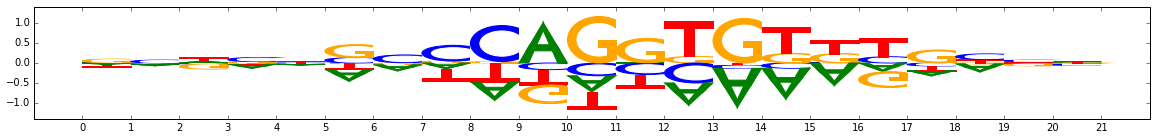

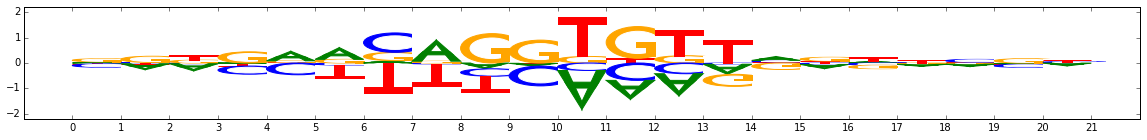

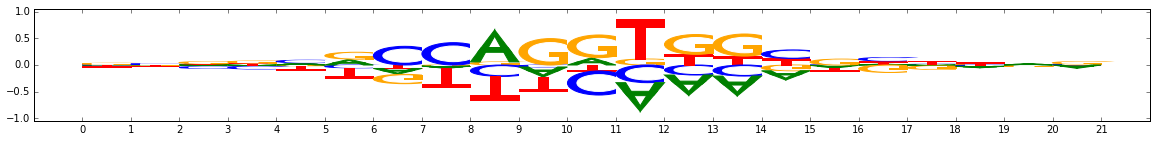

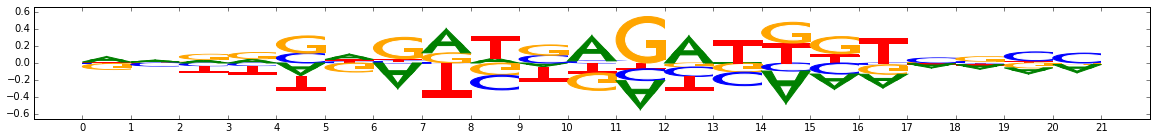

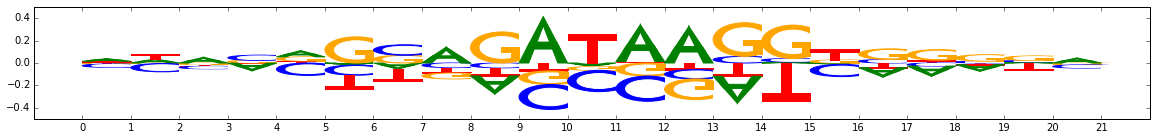

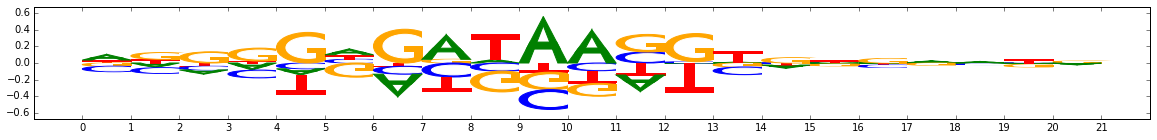

In [5]:
#print 5 seqlets drawn from across the range, as a sanity check
for i in range(0,len(seqlets),int(len(seqlets)/5)):
    viz_sequence.plot_weights(seqlets[i]["multipliers"].fwd)

In [6]:
from modisco import affinitymat as affmat
affinity_mat = affmat.MaxCrossCorrAffinityMatrixFromSeqlets(                    
                    track_names=["multipliers"],                                     
                    normalizer=affmat.MeanNormalizer().chain(affmat.MagnitudeNormalizer()),   
                    min_overlap=0.3).get_affinity_matrix(seqlets)

(501, 21, 4)
('On filters', 0, 'to', 11904)
('Done', 0)
(501, 21, 4)
('On filters', 0, 'to', 11904)
('Done', 0)


In [31]:
from modisco.cluster import core as mclust
ks_to_try = [30, 50, 100, 150, 200]
k_to_num_clusters = {}
for k in ks_to_try:
    cluster_results = mclust.PhenographCluster(k=k).cluster(affinity_mat=affinity_mat)
    k_to_num_clusters[k] = max(cluster_results.cluster_indices)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.125344991684 seconds
Jaccard graph constructed in 0.0903739929199 seconds
Wrote graph to binary file in 0.0111310482025 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.872993
Louvain completed 21 runs in 0.289891004562 seconds
PhenoGraph complete in 0.521067142487 seconds
Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.167572021484 seconds
Jaccard graph constructed in 0.144186973572 seconds
Wrote graph to binary file in 0.0175740718842 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.78514
Louvain completed 21 runs in 0.281023979187 seconds
PhenoGraph complete in 0.61572599411 seconds
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.121943950653 seconds
Jaccard graph constructed in 0.382266998291 seconds
Wrote gr

In [33]:
for k in ks_to_try:
    print("k: "+str(k)+" num_clusters: "+str(k_to_num_clusters[k]+1))

k: 30 num_clusters: 11
k: 50 num_clusters: 8
k: 100 num_clusters: 4
k: 150 num_clusters: 3
k: 200 num_clusters: 2


No colors supplied, so autogen'd as:
(0, (0, 1.0, 0.0))
(1, (0.5, 0, 0.5))


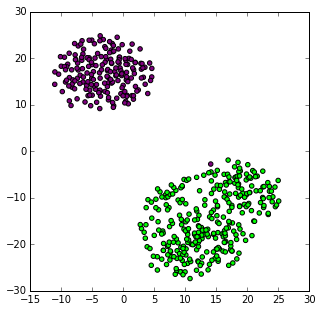

In [34]:
from modisco.visualization import tsne
reload(tsne)
import modisco
reload(modisco.visualization.matplotlibhelpers)

embedding = tsne.get_tsne_embedding(affinity_mat=affinity_mat, perplexity=50)
tsne.color_tsne_embedding_by_clustering(embedding=embedding, clusters=cluster_results.cluster_indices)

In [35]:
from collections import defaultdict
cluster_to_seqlets = defaultdict(list)
for cluster_val, seqlet in zip(cluster_results.cluster_indices, seqlets):
    cluster_to_seqlets[cluster_val].append(seqlet)

('ON cluster ', 0)


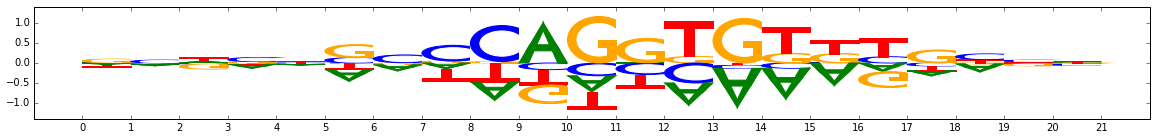

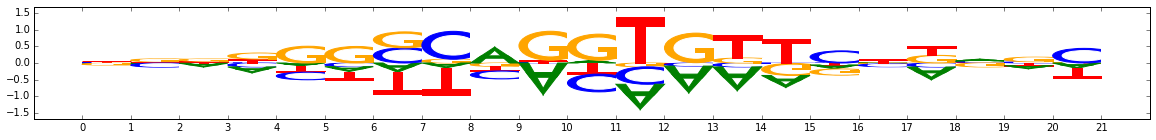

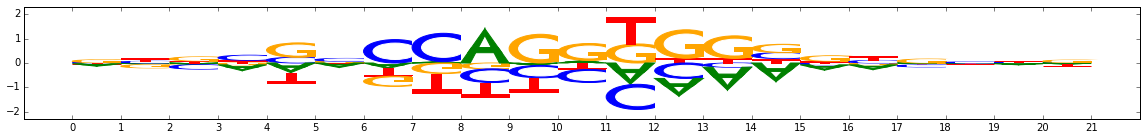

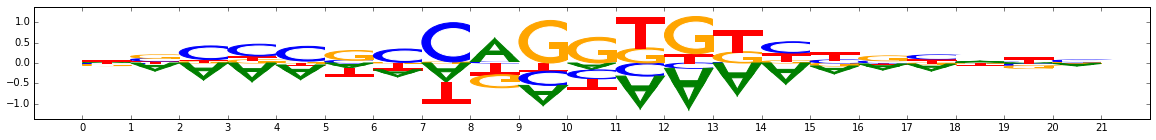

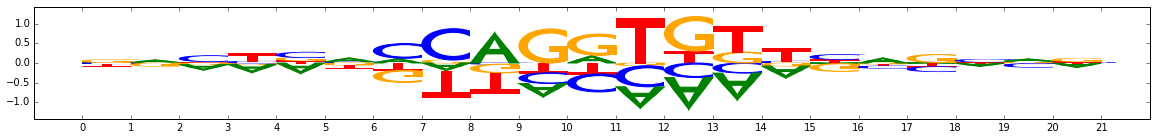

('ON cluster ', 1)


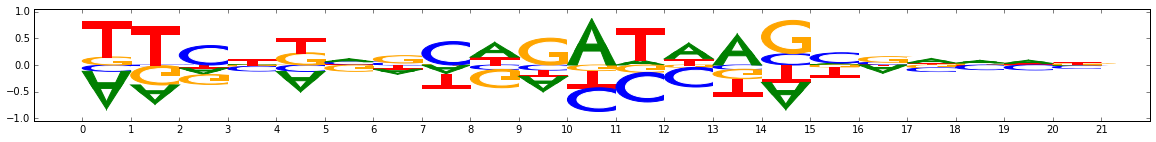

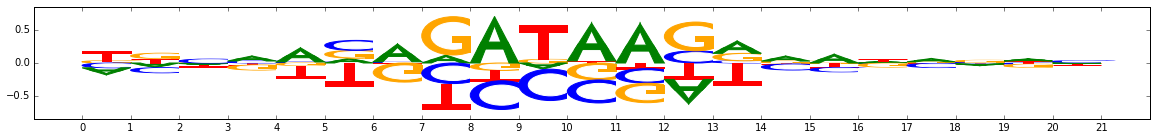

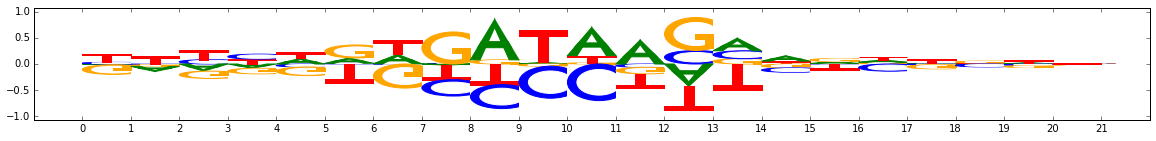

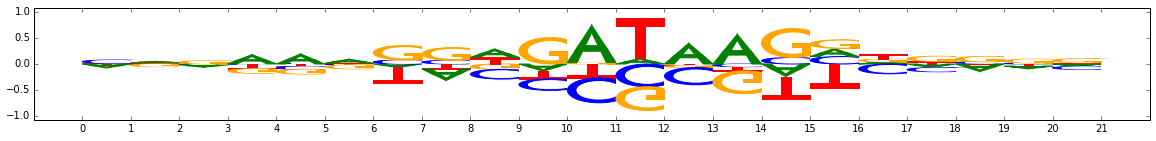

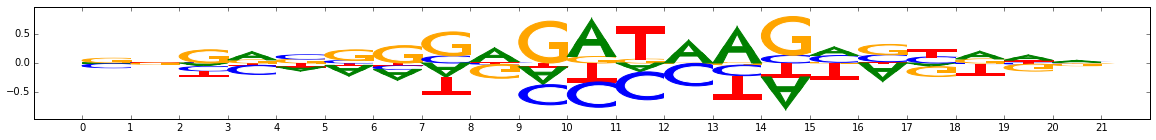

In [36]:
for i in range(max(cluster_results.cluster_indices)+1):
    print("ON cluster ",i)
    for j in range(5):
        viz_sequence.plot_weights(cluster_to_seqlets[i][j]["multipliers"].fwd)